In [9]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import math
import glob
import pickle
import statistics
import scipy.stats as stats
from sklearn.neighbors import KernelDensity
import dask
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
def getrange(numbers):
    return max(numbers) - min(numbers)

In [11]:
def get_files():
    models = glob.glob("/terra/data/cmip5/global/historical/*")
    avail={}
    for model in models:
        zg = glob.glob(str(model)+"/r1i1p1/day/native/zg*")
        try:
            test = zg[0]
            avail[model.split('/')[-1]] = zg
        except:
             pass
    return avail

In [12]:
files = get_files()
files['NOAA'] = glob.glob("/terra/data/reanalysis/global/reanalysis/NOAA/20thC/r1/day/native/z_day*")
files['ERA5'] = glob.glob("/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5/6hr/native/zg*")

In [13]:
results={}
for model in files.keys():
    print(model)
    x = xr.open_mfdataset(files[model])
    if model == 'NOAA':
        x = x.rename({'hgt':'zg'})
        x = x.rename({'level':'plev'})
        x = x.sel(plev=850)
        x = x.sel(time=slice('1950','2005'))
    elif model == 'ERA5':
        x = x.rename({'latitude':'lat'})
        x = x.rename({'longitude':'lon'})
        x = x.rename({'level':'plev'})
        x = x.sel(plev=850)
        x = x.sel(time=slice('1979','2005'))
    else:
        x = x.sel(plev=85000)
        x = x.sel(time=slice('1950','2005'))
        x = x.load()
    if model == 'ERA5':
        x = x.sel(lat=slice(0,-60))
    else:
        x = x.sel(lat=slice(-60,0))
    x = x[['zg']]
    x = x.assign_coords(lon=(((x.lon + 180) % 360) - 180))
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        x = x.sortby(x.lon)
    x = x.sel(lon=slice(-50,20))
    x = x.resample(time="QS-DEC").mean(dim="time",skipna=True)
    x = x.load()
    x['maxi']=x.zg
    for i in range(len(x.time)):
        x.maxi[i] = x.zg[i].where((x.zg[i]==np.max(x.zg[i])))
    east=[]
    south=[]
    pres=[]
    for i in range(len(x.time)):
        ids =  np.argwhere(~np.isnan(x.maxi[i].values))
        latsid = [item[0] for item in ids]
        lonsid = [item[1] for item in ids]
        east.append(x.lon.values[np.max(lonsid)])
        south.append(x.lat.values[np.max(latsid)])
        pres.append(x.maxi.values[i][np.max(latsid)][np.max(lonsid)])
    results[model]=pd.DataFrame(np.array([x.time.values,east,south,pres]).T,columns=['time','east','south','pres'])
    x.close()

IPSL-CM5A-LR


KeyboardInterrupt: 

In [ ]:
for model in results:
    l = len(results[model])
    bottom = results[model].south.mean() - 3*(results[model].south.std())
    top = results[model].south.mean() + 3*(results[model].south.std())
    bottom_e = results[model].east.mean() - 3*(results[model].east.std())
    top_e = results[model].east.mean() + 3*(results[model].east.std())
    results[model] = results[model].where((results[model].south > bottom) & (results[model].south<top))
    results[model] = results[model].where((results[model].east > bottom_e) & (results[model].east < top_e)).dropna()
    print(model,l-len(results[model]))

In [ ]:
results.pop('MIROC-ESM') #no variability

In [ ]:
scores = pd.DataFrame([],columns=['Model','Meridional','Zonal','Pressure'])
i = 1000
for model in results:
    #longitude
    x = np.linspace(min([np.min(results[key].east) for key in results]) , max([np.max(results[key].east) for key in results]) , int(i) )
    bw = 1.059*np.min([np.std(results['NOAA'].east.values),stats.iqr(results['NOAA'].east.values)/1.34])*216**(-1/5.)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.array(results['NOAA'].east.values)[:, np.newaxis]) # replicates sns
    ref = np.exp(kde.score_samples(x[:, np.newaxis]))
    #
    bw = 1.059*np.min([np.std(results[model].east.values),stats.iqr(results[model].east.values)/1.34])*216**(-1/5.)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.array(results[model].east.values)[:, np.newaxis]) # replicates sns
    cmip = np.exp(kde.score_samples(x[:, np.newaxis]))
    #
    score = []
    scale = getrange(x)/i
    for j in range(len(ref)):
        score.append(abs(ref[j]-cmip[j])*scale)
    meridional = np.sum(score)
    #latitude
    x = np.linspace(min([np.min(results[key].south) for key in results]) , max([np.max(results[key].south) for key in results]) , int(i) )
    bw = 1.059*np.min([np.std(results['NOAA'].south.values),stats.iqr(results['NOAA'].south.values)/1.34])*216**(-1/5.)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.array(results['NOAA'].south.values)[:, np.newaxis]) # replicates sns
    ref = np.exp(kde.score_samples(x[:, np.newaxis]))
    #
    bw = 1.059*np.min([np.std(results[model].south.values),stats.iqr(results[model].south.values)/1.34])*216**(-1/5.)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.array(results[model].south.values)[:, np.newaxis]) # replicates sns
    cmip = np.exp(kde.score_samples(x[:, np.newaxis]))
    #
    score = []
    scale = getrange(x)/i
    for j in range(len(ref)):
        score.append(abs(ref[j]-cmip[j])*scale)
    zonal = np.sum(score)
    #pressure
    x = np.linspace(min([np.min(results[key].pres) for key in results]) , max([np.max(results[key].pres) for key in results]) , int(i) )
    bw = 1.059*np.min([np.std(results['NOAA'].pres.values),stats.iqr(results['NOAA'].pres.values)/1.34])*216**(-1/5.)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.array(results['NOAA'].pres.values)[:, np.newaxis]) # replicates sns
    ref = np.exp(kde.score_samples(x[:, np.newaxis]))
    #
    bw = 1.059*np.min([np.std(results[model].pres.values),stats.iqr(results[model].pres.values)/1.34])*216**(-1/5.)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.array(results[model].pres.values)[:, np.newaxis]) # replicates sns
    cmip = np.exp(kde.score_samples(x[:, np.newaxis]))
    #
    score = []
    scale = getrange(x)/i
    for j in range(len(ref)):
        score.append(abs(ref[j]-cmip[j])*scale)
    pres = np.sum(score)
    scores.loc[len(scores)] = [model,meridional,zonal,pres]
    

In [ ]:
inttype = type(results['NOAA'].time[1])
for index in results:
    if isinstance(results[index].time[1], inttype):
        results[index].time = pd.to_datetime(results[index].time)
    
for index in results:
    results[index].east = pd.to_numeric(results[index].east)
    results[index].south = pd.to_numeric(results[index].south)
    results[index].pres = pd.to_numeric(results[index].pres)

In [ ]:
pickle.dump( scores, open( "../HIGH_OUT/scores_1D.p", "wb" ) )
pickle.dump( results, open( "../HIGH_OUT/tracker_1D.p", "wb" ) )

In [7]:
out = pickle.load( open( "../HIGH_OUT/tracker_1D.p", "rb" ) )

FileNotFoundError: [Errno 2] No such file or directory: '../HIGH_OUT/tracker_1D.p'

In [ ]:
for index in out:
    if index == 'NOAA':
        skip
    else:
        df  = out['NOAA']
        df['model'] = 'NOAA'
        df2 = out[index]
        df2['model'] = str(index)
        df = df.append(df2)
        g = sns.jointplot(data= df,x='east',y = 'south', hue="model",kind="kde",fill=True,  palette=["blue","red"],joint_kws={'alpha': 0.6} )
        g.plot_joint(sns.scatterplot, s=30, alpha=.5)
        g.ax_joint.set_xlabel('Longitude')
        g.ax_joint.set_ylabel('Latitude')
        plt.savefig('../HIGH_OUT/jointplots/jointplot_'+str(index)+'.png',dpi=100)
        plt.savefig('../HIGH_OUT/jointplots/jointplot_'+str(index)+'.pdf')
        plt.close()

In [38]:
NOAA = out['NOAA']
seasons =[]
for i in range(len(NOAA.time)):
    if NOAA.iloc[i].time.month == 12:
        seasons.append('Summer')
    elif NOAA.iloc[i].time.month == 3:
        seasons.append('Autumn')
    elif NOAA.iloc[i].time.month == 6:
        seasons.append('Winter')
    else:
        seasons.append('Spring')


NOAA['Season'] = seasons

In [39]:
NOAA

,time,east,south,pres,season,Season
0,1949-12-01,-11.0,-29.0,1546.673096,Summer,Summer
1,1950-03-01,-18.0,-26.0,1539.696533,Autumn,Autumn
2,1950-06-01,-27.0,-24.0,1557.934326,Winter,Winter
3,1950-09-01,-8.0,-27.0,1545.378662,Spring,Spring
4,1950-12-01,-16.0,-30.0,1554.858643,Summer,Summer
...,...,...,...,...,...,...
220,2004-12-01,-12.0,-29.0,1552.706909,Summer,Summer
221,2005-03-01,-14.0,-28.0,1558.829102,Autumn,Autumn
222,2005-06-01,-22.0,-26.0,1568.382690,Winter,Winter
223,2005-09-01,-11.0,-27.0,1553.906250,Spring,Spring


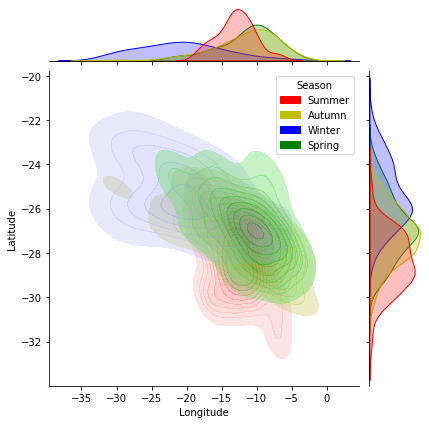

In [40]:
df  = NOAA
g = sns.jointplot(data= df,x='east',y = 'south',hue='Season',kind="kde",fill=True,  palette=['r','y','b','g'],joint_kws={'alpha': 0.35})
g.ax_joint.set_xlabel('Longitude')
g.ax_joint.set_ylabel('Latitude')
#plt.savefig('../HIGH_OUT/NOAA_seasonality_jointplot.png',dpi=1000)
plt.savefig('../HIGH_OUT/NOAA_seasonality_jointplot.pdf')

In [105]:
f = open("../HIGH_OUT/out_dict.txt","w") #ipython dicts cant be read by .py
f.write( str(out) )
f.close()

In [128]:
results_df = pd.DataFrame([],columns=["model", "Mean Latitude" ,"Latitude Difference","Latitude std.","Latitude Range", "Mean Longitude" ,"Longitude Difference" ,"longitude std.", "Longitude Range"])
for index in df.index:
         results_df.loc[len(results_df)] = [index,round(np.mean(out[index].south),2),round(np.mean(out[index].south-np.mean(out['NOAA'].south)),2), round(np.std(out[index].south),2),round(getrange(out[index].south),2),round(np.mean(out[index].east),2),round(np.mean(out[index].east-np.mean(out['NOAA'].east)),2),round(np.std(out[index].east),2),round(getrange(out[index].east),2)]
    

In [133]:
for index in df.index:
    print(index)

NOAA
ACCESS1-0
ERA5
HadGEM2-CC
MIROC-ESM-CHEM
BNU-ESM
ACCESS1-3
bcc-csm1-1
MIROC5
bcc-csm1-1-m
EC-EARTH
GFDL-ESM2G
IPSL-CM5B-LR
CMCC-CM
GFDL-ESM2M
CNRM-CM5
MPI-ESM-P
IPSL-CM5A-LR
MPI-ESM-MR
HadCM3
MPI-ESM-LR
CanESM2
CMCC-CMS
GFDL-CM3
CMCC-CESM
HadGEM2-AO
IPSL-CM5A-MR
NorESM1-M
FGOALS-g2
MRI-ESM1
MRI-CGCM3


In [131]:
results_df.to_csv('../HIGH_OUT/results_table.csv',float_format='%.2f')

In [130]:
#for index in df.index:
#    print('\subcaptionbox{'+str(index)+'\label{CMIP5 Fig2}}{\includegraphics[width = 2.6cm]{/home/peter/Documents/MASTERS/HIGH/HIGH_OUT/jointplots/jointplot_'+str(index)+'}}')


/share/apps/anaconda3/envs/dask/lib/python3.8/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


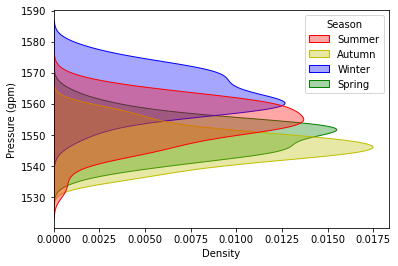

In [53]:
fig = sns.kdeplot(data=NOAA,y='pres',hue='Season',fill=True,alpha=0.35, palette=['r','y','b','g'])
plt.ylabel('Pressure (gpm)')
plt.savefig('../HIGH_OUT/NOAA_seasonality_pressure.png',dpi=1000)
plt.savefig('../HIGH_OUT/NOAA_seasonality_pressure.pdf')

In [71]:
results_df=pd.DataFrame([],columns=('Model','Mean','Difference', 'Std.','Range','Mean', 'Difference', 'Std.','Range','Mean','Difference', 'Std.','Range'))
for index in out.keys():
    results_df.loc[len(results_df)] = [index,round(np.mean(out[index].south),2),round(np.mean(out[index].south-np.mean(out['NOAA'].south)),2), round(np.std(out[index].south),2),round(getrange(out[index].south),2),round(np.mean(out[index].east),2),round(np.mean(out[index].east-np.mean(out['NOAA'].east)),2),round(np.std(out[index].east),2),round(getrange(out[index].east),2),round(np.mean(out[index].pres),2),round(np.mean(out[index].pres-np.mean(out['NOAA'].pres)),2),round(np.std(out[index].pres),2),round(getrange(out[index].pres),2)]


In [73]:
results_df.to_csv('../HIGH_OUT/results_table_1D.csv')

In [14]:
scores = pickle.load( open( "../HIGH_OUT/scores_1D.p", "rb" ) )

In [26]:
for model in scores.Model:
    print('\subcaptionbox{'+str(model)+'\label{Figure 18}}{\includegraphics[width = 2cm]{../HIGH/HIGH_OUT/jointplots/pdf/jointplot_'+str(model)+'.pdf}}')

\subcaptionbox{IPSL-CM5A-LR\label{Figure 18}}{\includegraphics[width = 2cm]{../HIGH/HIGH_OUT/jointplots/pdf/jointplot_IPSL-CM5A-LR.pdf}}
\subcaptionbox{MPI-ESM-MR\label{Figure 18}}{\includegraphics[width = 2cm]{../HIGH/HIGH_OUT/jointplots/pdf/jointplot_MPI-ESM-MR.pdf}}
\subcaptionbox{MRI-ESM1\label{Figure 18}}{\includegraphics[width = 2cm]{../HIGH/HIGH_OUT/jointplots/pdf/jointplot_MRI-ESM1.pdf}}
\subcaptionbox{MIROC-ESM-CHEM\label{Figure 18}}{\includegraphics[width = 2cm]{../HIGH/HIGH_OUT/jointplots/pdf/jointplot_MIROC-ESM-CHEM.pdf}}
\subcaptionbox{EC-EARTH\label{Figure 18}}{\includegraphics[width = 2cm]{../HIGH/HIGH_OUT/jointplots/pdf/jointplot_EC-EARTH.pdf}}
\subcaptionbox{HadGEM2-CC\label{Figure 18}}{\includegraphics[width = 2cm]{../HIGH/HIGH_OUT/jointplots/pdf/jointplot_HadGEM2-CC.pdf}}
\subcaptionbox{bcc-csm1-1-m\label{Figure 18}}{\includegraphics[width = 2cm]{../HIGH/HIGH_OUT/jointplots/pdf/jointplot_bcc-csm1-1-m.pdf}}
\subcaptionbox{FGOALS-g2\label{Figure 18}}{\includegraphics[w

In [ ]:
print('\subcaptionbox{'+str(model)+'\label{Figure 18}}{\includegraphics[width = 3.2cm,trim={1.8cm 1cm 1.8cm 1cm},clip]{/home/peter/Documents/MASTERS/HIGH/HIGH_OUT/anom_contour_plots/pdf/'+str(model)+'}}'